In [1]:
! pip3 install pyro-ppl 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
os.chdir("/content/drive/MyDrive")
files = os.listdir("./")
# print(files)
if "Results" not in files:
  os.mkdir("./Results")
!ls Results/
os.chdir("/content/drive/MyDrive/Results/Test")

print("")
!ls

250_100_True
250_200_True
250_500_False_simple_model_True_try_num_1
250_500_False_simple_model_True_try_num_3
250_500_True
250_500_True_simple_model_False
250_500_True_simple_model_False_try_num_1
250_500_True_simple_model_True
250_500_True_simple_model_True_try_num_1
250_500_True_simple_model_True_try_num_2
250_500_True_simple_model_True_try_num_3
250_500_True_simple_model_True_try_num_4
Test

all_betas.pdf				      linear_model_res.pdf
best_modedl.pt				      phenotypes_dist_cont.pdf
beta_marginal.csv			      phenotypes_dist.pdf
betas_sample.csv			      phenotypes_dist_together.pdf
boxplot_greatest_values_predicted_betas.pdf   proposed_model_res.pdf
boxplot_lowest_values_predicted_betas.pdf     res_dict
boxplot_original_betas_greater_than_zero.pdf  X_test.csv
boxplot_original_betas_lower_than_zero.pdf    X_train.csv
boxplot_original_betas_non_zero.pdf	      y_test.csv
LD.csv					      y_train.csv


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from torch.distributions.multivariate_normal import MultivariateNormal

import torch
import torch.nn as nn
import pyro
from pyro.distributions import Binomial, Normal
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch import optim

from tqdm import tqdm

import scipy.stats as stats
from scipy.stats import bernoulli, binom
from sklearn import linear_model

from numpy import asarray
from numpy import savetxt

# np.random.seed(33)

# try_num = 4

# # Size

# n = 250
# d = 500
# # K = 100
# p = 0.5


REP = 20
# total_beta_sample = 100

num_epochs = 5000
EPSILON = 1
lambda_val = 0.02
BATCH_SIZE = 64


# first = True
simple_model = False

# #Genarating Genotypes

# toy_genotypes = binom.rvs(2, p, size=(n * 3, d))
# np.random.shuffle(toy_genotypes)

# print(toy_genotypes.shape)

# print(np.mean(toy_genotypes))
# print(np.var(toy_genotypes))



RES_DICT = {'REP': REP, 'BATCH_SIZE': BATCH_SIZE}


In [4]:
# test_genotypes = np.genfromtxt("test_genotypes.csv")
# train_genotypes = np.genfromtxt("train_genotypes.csv")
# val_genotypes = np.genfromtxt("val_genotypes.csv")

# test_phenotypes = np.genfromtxt("test_phenotypes.csv")
# train_phenotypes = np.genfromtxt("train_phenotypes.csv")
# val_phenotypes = np.genfromtxt("val_phenotypes.csv")

# betas = np.genfromtxt("betas.csv")

# proper_beta_samples = np.genfromtxt("betas_sample.csv")

# print(betas)
# print(betas_sample)

In [5]:
# beta_marginal.csv  LD.csv  X_train.csv	y_train.csv
import pandas as pd
betas = pd.read_csv("beta_marginal.csv", index_col=0)
causal = [betas.index.to_list().index('rs9482449'),
          betas.index.to_list().index('rs7771989'),
          betas.index.to_list().index('rs2169092')]

print(causal)

betas = betas.to_numpy().squeeze()

print(betas.shape, 'betas')

LD = pd.read_csv("LD.csv", index_col=0)
LD = LD.to_numpy()

print(LD.shape, 'LD')

train_genotypes = pd.read_csv("X_train.csv", index_col=0)
train_genotypes = train_genotypes.to_numpy()
train_phenotypes = pd.read_csv("y_train.csv", index_col=0)
train_phenotypes = train_phenotypes.to_numpy().squeeze()

val_num = 88
# val_num = train_phenotypes.shape[0]

val_genotypes = train_genotypes[0:val_num,:]
val_phenotypes = train_phenotypes[0:val_num,]

train_genotypes = train_genotypes[val_num:,:]
train_phenotypes = train_phenotypes[val_num:,]

print(train_genotypes.shape, 'Training Data')
print(val_genotypes.shape, 'Validation Data')

test_genotypes = pd.read_csv("X_test.csv", index_col=0)
test_genotypes = test_genotypes.to_numpy()
test_phenotypes = pd.read_csv("y_test.csv", index_col=0)
test_phenotypes = test_phenotypes.to_numpy().squeeze()
print(test_genotypes.shape, 'Test Data')



[99, 0, 62]
(100,) betas
(100, 100) LD
(350, 100) Training Data
(88, 100) Validation Data
(51, 100) Test Data


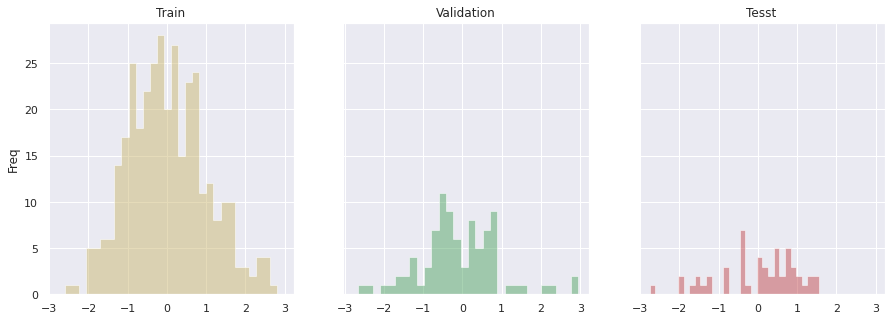

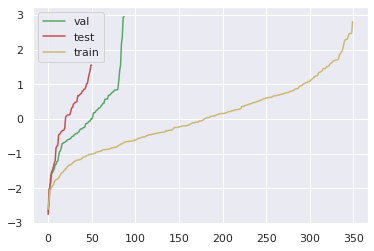

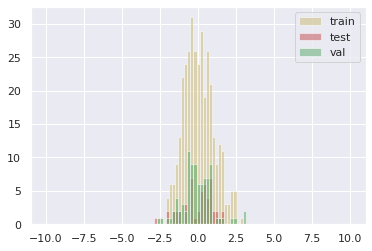

0.7011325650535869 validation
0.604296290501452 validation correlation
0.3725713026912453 train
0.7904563343832133 train correlation
0.8667053629901674 test
0.41436825261051885 test correlation



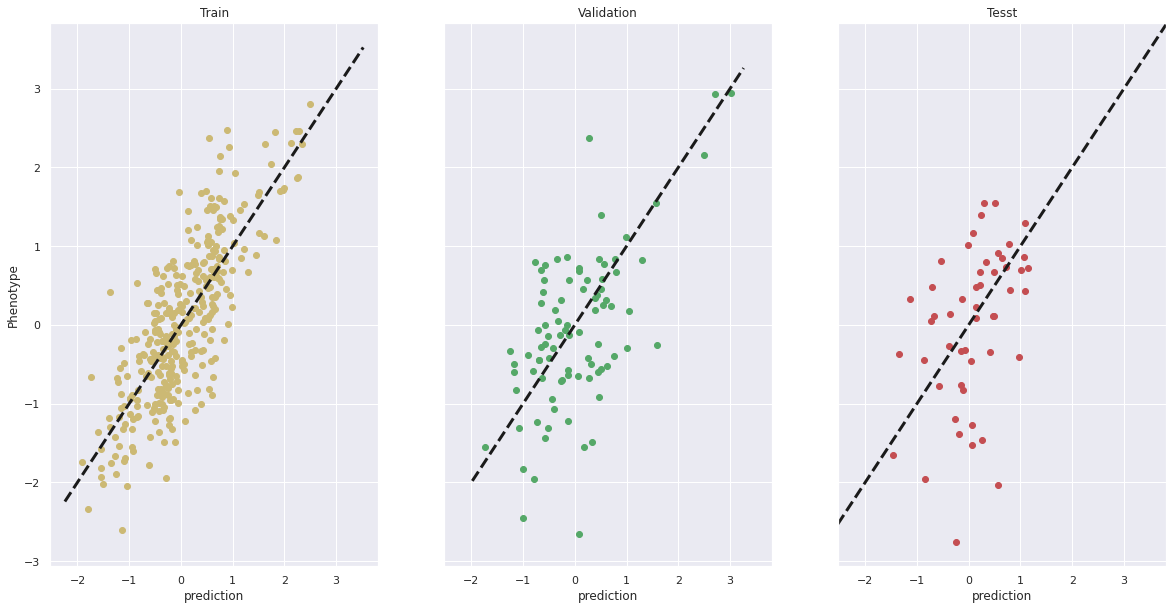

In [6]:
figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(15,5))

axis[0].hist(train_phenotypes, color='y', bins=30, alpha=0.5, histtype='stepfilled')
axis[0].set_title("Train")

axis[1].hist(val_phenotypes, color='g', bins=30, alpha=0.5, histtype='stepfilled')
axis[1].set_title("Validation")

axis[2].hist(test_phenotypes, color='r', bins=30, alpha=0.5, histtype='stepfilled')
axis[2].set_title("Tesst")

for ax in axis.flat:
    ax.set(ylabel='Freq')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

print("")
plt.show()
figure.savefig('phenotypes_dist.pdf')

plt.plot(np.sort(val_phenotypes), color='g', label='val')
plt.plot(np.sort(test_phenotypes), color='r', label='test')
plt.plot(np.sort(train_phenotypes), color='y', label='train')
plt.legend(loc='upper left')
print("")
plt.savefig('phenotypes_dist_cont.pdf')
plt.show()

bins = np.linspace(-10, 10, 100)

plt.hist(train_phenotypes, bins, alpha=0.5, color='y', label='train')
plt.hist(test_phenotypes, bins, alpha=0.5, color='r', label='test')
plt.hist(val_phenotypes, bins, alpha=0.5, color='g', label='val')

plt.legend(loc='upper right')
plt.savefig('phenotypes_dist_together.pdf')
print("")
plt.show()

from sklearn import svm
from scipy.stats import pearsonr

reg = linear_model.Ridge(alpha=.5)
reg.fit(train_genotypes, train_phenotypes)


figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,10))

per = reg.predict(val_genotypes)

# plt.xticks(np.arange(-0.5, 0.5, 0.05))
# plt.yticks(np.arange(-0.5, 0.5, 0.01))

axis[1].scatter(per, val_phenotypes, color='g')
axis[1].set_title("Validation")
xpoints = ypoints = plt.xlim()
axis[1].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

# EPSILON_PREV = np.mean((val_phenotypes - per) ** 2)

RES_DICT['linear model validation'] = np.mean((val_phenotypes - per) ** 2)
print(np.mean((val_phenotypes - per) ** 2), 'validation')
print(pearsonr(val_phenotypes, per)[0], 'validation correlation')


del per

per = reg.predict(train_genotypes)

axis[0].scatter(per, train_phenotypes, color='y')
axis[0].set_title("Train")
xpoints = ypoints = plt.xlim()
axis[0].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

RES_DICT['linear model train'] = np.mean((train_phenotypes - per) ** 2)
print(np.mean((train_phenotypes - per) ** 2), 'train')
print(pearsonr(train_phenotypes, per)[0], 'train correlation')


del per

per = reg.predict(test_genotypes)


axis[2].scatter(per, test_phenotypes, color='r')
axis[2].set_title("Tesst")

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
RES_DICT['linear model test'] = np.mean((test_phenotypes - per) ** 2)
print(np.mean((test_phenotypes - per) ** 2), 'test')
print(pearsonr(test_phenotypes, per)[0], 'test correlation')




for ax in axis.flat:
    ax.set(ylabel='Phenotype', xlabel='prediction')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

print("")
# plt.xlim(-1,1)
plt.show()
figure.savefig('linear_model_res.pdf')






0.2020007871816033
100


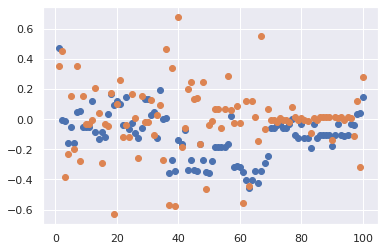

0.17397749679238728


In [7]:

print(np.mean(np.abs(reg.coef_ - betas)))
print(len(betas[betas != 0]))
plt.scatter(np.arange(len(betas[betas != 0])) + 1, betas[betas != 0])
plt.scatter(np.arange(len(betas[betas != 0])) + 1, reg.coef_[betas != 0])

plt.show()

print(pearsonr(betas, reg.coef_)[0])

In [8]:
class Loader(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, genotype_matrix, phenotypes, batch_size=1):

        self.phenotypes = phenotypes
        self.genotype_matrix = genotype_matrix

        self.batch_size = batch_size

    def __len__(self):
        return len(self.genotype_matrix)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        real_samples = self.genotype_matrix[idx, ]        
        samples = real_samples
        labels = self.phenotypes[idx, ]
        batch = {'x': samples.astype(np.float64), 'y': labels}

        return batch

    
    
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data    

dataset = Loader(train_genotypes, train_phenotypes)

from pyro.distributions import Normal, Gamma, MultivariateNormal
# from scipy.stats import gamma
alpha_gam = 1
beta_gam = 0.7

# from scipy.stats import norm


def prior_sample(size=1):
    gamma_dist = Gamma(alpha_gam, 1 / beta_gam)
    sigma = gamma_dist.sample(sample_shape=torch.Size([size]))

    normal_dist = Normal(0, sigma)
    beta = normal_dist.sample()
    return beta, sigma

def prior_prob(beta, sigma):
    gamma_dist = Gamma(alpha_gam, 1 / beta_gam, validate_args=True)
    p_sig = torch.exp(gamma_dist.log_prob(sigma))
    normal_dist = Normal(0, sigma)
    p_beta = torch.exp(normal_dist.log_prob(beta))
    
    return p_beta, p_sig


# from scipy.stats import multivariate_normal

def metropolis_heisting(cur_beta, cur_sigma, cur_prob_theta, geno_mat, h_classifier):
    
#     changed_value = np.full(cur_theta_prob.shape, 1)
    counter = 0

    while(True):
        new_beta = MultivariateNormal(cur_beta.float(), var.float()).sample()
        new_sigma = MultivariateNormal(cur_sigma.float(), var.float()).sample()

        # new_beta = torch.clip(new_beta, -2, 2)

        beta_prob, sigma_prob = prior_prob(new_beta, cur_sigma)
        new_ys = torch.matmul(geno_mat.float(), new_beta)
        with torch.no_grad():
            r_value = h_classifier(new_ys, geno_mat, new_beta, cur_sigma)
            r_value = torch.mean(r_value, dim=0)
            r_value = r_value / (1 - r_value)
            new_theta_prob = r_value * beta_prob * sigma_prob

            rho = ((new_theta_prob) / (cur_prob_theta + 1e-7)).cpu().detach().numpy()
            rho[rho > 1] = 1
    #         rho = rho * changed_value
    #        rho = min(1, (new_theta_prob)/(cur_theta_prob))
            random_num = np.random.rand()
            if np.isnan(np.sum(rho)):
                print("EROR ------------------------")
                print(np.isnan(np.sum(cur_prob_theta)))
                print(np.isnan(np.sum(new_prob_theta)))

            if random_num < np.mean(rho):
                cur_beta = new_beta
                cur_sigma = cur_sigma
                cur_theta_prob = new_theta_prob
                # cur_beta = 1 / (1 + np.exp(-1 * cur_beta))
                return cur_sigma, cur_beta, cur_theta_prob, new_ys

        counter += 1
        
        if counter > REP:
#             print("It Takes quite time :(")
            cur_beta = (new_beta + cur_beta) / 2
            cur_sigma = (new_sigma + cur_sigma) / 2
            cur_theta_prob = (new_theta_prob + cur_prob_theta) / 2
            # cur_beta = 1 / (1 + np.exp(-1 * cur_beta))
            return cur_sigma, cur_beta, cur_theta_prob, new_ys

class Classifier(nn.Module):
    
    def __init__(self, input_dim, num_classes=1):
        super(Classifier, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)
#         self.activation = nn.Sigmoid()

        # Number of input features is 12.
        # self.layer_1 = nn.Linear(input_dim, 1)
        # self.act1 = nn.ReLU()
        self.layer_out = nn.Linear(2, 1)
        self.out = nn.LogSoftmax(dim=1)
        

        self.criterion = nn.BCEWithLogitsLoss()
        
    def cross_entropy(self, x, y):
        n_d, h_d = x.shape
        
        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]
        
        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))
        
    def forward(self, y, genotypes_batch, beta, label=None, testing=False):

        y = torch.tensor(y).to(device).float()
        beta = torch.Tensor(beta).to(device)[:, None].float()
        genotypes_batch = torch.tensor(genotypes_batch).to(device).float()

        comparison_vector = torch.matmul(genotypes_batch, beta)
        
        # beta_summaries = self.act1(self.layer_1(beta))

        # x = torch.cat([y[:, None], torch.repeat_interleave(beta_summaries[None, :], y.shape[0], dim=0)], dim=1)
        x = torch.cat([y[:, None], comparison_vector], dim=-1)

        x = self.layer_out(x)

        logits = self.out(x)

        if label is not None:
            probs = torch.exp(logits) + 1e-6  
            if testing:
              labels = probs.clone().squeeze()
              labels[labels >= 0.5] = 1
              labels[labels < 0.5] = 0
              print(torch.sum(torch.abs(labels - label)), "Wrong Preds out of", len(label))

              return [], []

            loss = self.criterion(probs, label[:, None])
            return probs, loss
        
        return torch.exp(logits[:,-1]) + 1e-6
    
    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp


class LogisticRegression(nn.Module):
    
    def __init__(self, input_dim, num_classes=1):
        super(LogisticRegression, self).__init__()
#         self.linear = nn.Linear(input_dim, 1)
#         self.activation = nn.Sigmoid()

        # Number of input features is 12.

        self.discriminator = nn.Sequential(nn.Conv1d(1, 32, kernel_size=6, stride=2),
                                           nn.LeakyReLU(0.2, inplace=0.2),
                                           nn.Dropout(0.5),
                                           nn.Conv1d(32, 16, kernel_size=6, stride=3),
                                           nn.LeakyReLU(0.2, inplace=True),
                                           nn.Dropout(0.3),
                                           nn.Conv1d(16, 4, kernel_size=6, stride=4),
                                           nn.LeakyReLU(0.2, inplace=True),
                                           nn.Dropout(0.1),
                                           nn.Conv1d(4, 1, kernel_size=5, dilation=1),
                                           nn.LeakyReLU(0.2, inplace=True))

        self.layer_out = nn.Sequential(nn.Linear(6, 1),
                                       nn.Sigmoid())
        
        # self.relu = nn.ReLU()
        # self.dropout = nn.Dropout(p=0.1)
        # self.batchnorm1 = nn.BatchNorm1d(64)
        # self.batchnorm2 = nn.BatchNorm1d(64)

        self.criterion = torch.nn.BCELoss(size_average=False)

        
    def cross_entropy(self, x, y):
        n_d, h_d = x.shape
        
        n_theta = x[0: int(n_d / 2),:]
        n_x = x[int(n_d / 2):,:]
        
        return (1 / n_d) * (torch.sum(torch.exp(-(n_theta))) + torch.sum(torch.exp(n_x)))
        
    def forward(self, y, genotypes_batch, beta, sigma, label=None, testing=False):

        y = torch.tensor(y).to(device).float()
        beta = torch.tensor(beta).to(device).float()
        sigma = torch.tensor(sigma).to(device).float()
        
        gamma_dist = Gamma(alpha_gam, 1 / beta_gam)
        sigma_n = gamma_dist.sample(sample_shape=sigma.shape)

        normal_dist = Normal(0, sigma_n)
        beta_f = normal_dist.sample()
        genotypes_batch = torch.tensor(genotypes_batch).to(device).float()

        pheno_fake_f = torch.matmul(genotypes_batch, beta)[:, None]
        pheno_fake_s = torch.matmul(genotypes_batch, beta_f)[:, None]
        y = y[:, None]


        # y = torch.Tensor(y).to(device)
        # beta = torch.Tensor(beta).to(device)
        
        # y = torch.repeat_interleave(y[:, None], d, dim=-1)
        # beta = torch.repeat_interleave(beta[None, :], y.shape[0], dim=0)
        
        x = torch.cat([beta, sigma], dim=-1)[None, None, :]
        
#         out = self.linear(x)
#         out = self.activation(out)
        x = self.discriminator(x).squeeze()

        x = torch.repeat_interleave(x[None, :], y.shape[0], dim=0)
        lab_vec = torch.cat([y, pheno_fake_f, pheno_fake_s], dim=-1)
        aux_loss = nn.MSELoss()(x, lab_vec)
        x = torch.cat([x, lab_vec], dim=-1)

        # x = self.batchnorm1(x)

        # x = self.batchnorm2(x)
        # x = self.dropout(x)
        # x = torch.squeeze(self.layer_out(x))

        probs = self.layer_out(x)

        # print(x[x>0].shape, "CLASSIFIER")
        # input()
        
        if label is not None:

            loss = self.criterion(probs, label[:, None])

            if testing:
              predicted = torch.round(probs).squeeze()
              print(float((len(label) - torch.sum(torch.abs(predicted - label)))) / len(label) * 100.0, " % acc")

              return torch.sum(torch.abs(predicted - label))

            return probs, loss + aux_loss
        
        return probs
    
    def get_n_params(model):
        pp=0
        for p in list(model.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Running\ on the CPU
1
3728


  0%|          | 0/5000 [00:00<?, ?it/s]

---------
Validation distance: 1.0765525885996736
Validation correlation: -0.22691007572730315
EPOCH 0
Total Error tensor(1792.7845, grad_fn=<DivBackward0>)
0 LEN


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:225: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:226: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:224: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(

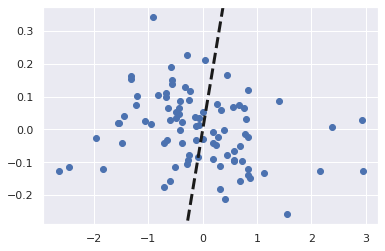

 10%|█         | 500/5000 [00:48<07:07, 10.53it/s]


9.090909090909092  % acc
100.0  % acc
54.54545617103577 %
Best modedl changed
---------
Validation distance: 0.9159102255029222
Validation correlation: 0.4985714318405294
EPOCH 500
Total Error tensor(420.5140, grad_fn=<DivBackward0>)
1 LEN


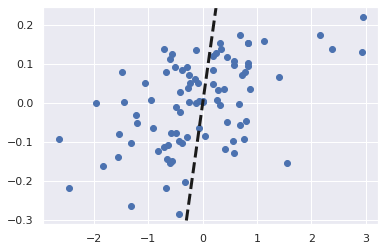

 20%|█▉        | 999/5000 [01:36<06:17, 10.60it/s]


36.36363636363637  % acc
57.95454545454546  % acc
47.159090638160706 %
---------
Validation distance: 0.9378981396239848
Validation correlation: 0.3813258301881227
EPOCH 1000
Total Error tensor(827.9046, grad_fn=<DivBackward0>)
3 LEN


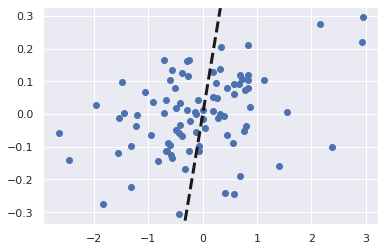

 30%|███       | 1500/5000 [02:23<05:18, 10.99it/s]


38.63636363636363  % acc
59.09090909090909  % acc
48.86363744735718 %
---------
Validation distance: 0.9148671368057131
Validation correlation: 0.4396332722596529
EPOCH 1500
Total Error tensor(1649.9417, grad_fn=<DivBackward0>)
6 LEN


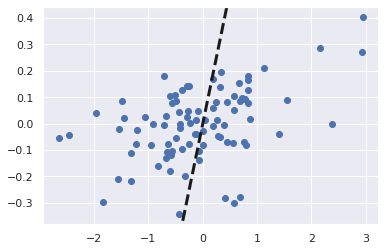

 40%|███▉      | 1999/5000 [03:10<04:51, 10.31it/s]


44.31818181818182  % acc
50.0  % acc
47.159090638160706 %
---------
Validation distance: 0.9157313716335587
Validation correlation: 0.43586375144518846
EPOCH 2000
Total Error tensor(1045.1517, grad_fn=<DivBackward0>)
7 LEN


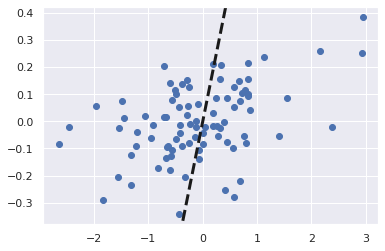

 50%|█████     | 2500/5000 [04:05<04:50,  8.60it/s]


76.13636363636364  % acc
50.0  % acc
63.06818127632141 %
Best modedl changed
---------
Validation distance: 0.9275099118021513
Validation correlation: 0.3917621205661053
EPOCH 2500
Total Error tensor(1565.9470, grad_fn=<DivBackward0>)
9 LEN


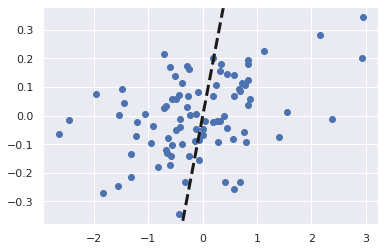

 60%|██████    | 3000/5000 [05:01<03:38,  9.14it/s]


96.5909090909091  % acc
51.13636363636363  % acc
73.86363744735718 %
Best modedl changed
---------
Validation distance: 0.9257032201606665
Validation correlation: 0.3845110389737879
EPOCH 3000
Total Error tensor(1421.2865, grad_fn=<DivBackward0>)
10 LEN


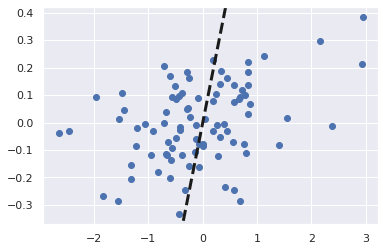

 70%|███████   | 3500/5000 [05:51<02:19, 10.72it/s]


100.0  % acc
35.22727272727273  % acc
67.61363744735718 %
---------
Validation distance: 0.9155261337274596
Validation correlation: 0.3863423060375372
EPOCH 3500
Total Error tensor(584.5167, grad_fn=<DivBackward0>)
13 LEN


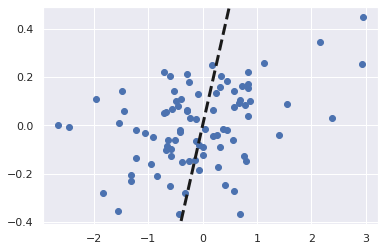

 80%|███████▉  | 3999/5000 [06:37<01:28, 11.26it/s]


0.0  % acc
62.5  % acc
31.25 %
---------
Validation distance: 0.9109295324594922
Validation correlation: 0.40073581225515204
EPOCH 4000
Total Error tensor(1023.7616, grad_fn=<DivBackward0>)
14 LEN


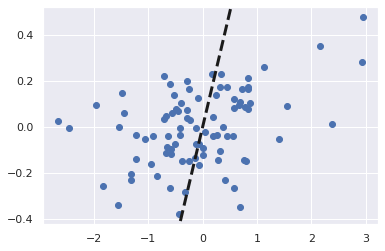

 90%|████████▉ | 4499/5000 [07:24<00:45, 11.02it/s]


44.31818181818182  % acc
51.13636363636363  % acc
47.72727191448212 %
---------
Validation distance: 0.9295380574631694
Validation correlation: 0.34603015875454324
EPOCH 4500
Total Error tensor(564.8339, grad_fn=<DivBackward0>)
16 LEN


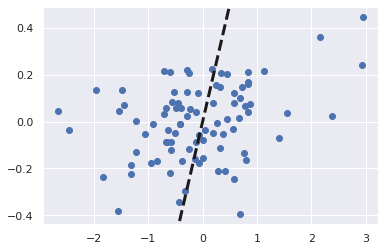

100%|██████████| 5000/5000 [08:10<00:00, 10.19it/s]


In [9]:
threshold = 0.84
# cor_thresh = 0.6
d = train_genotypes.shape[1]
print_freq = 10

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running\ on the CPU")

print(EPSILON)


data_loader = DataLoader(dataset, batch_size=BATCH_SIZE)

if simple_model:
  classifier = Classifier(d).to(device)
else:
  classifier = LogisticRegression(d * 2).to(device)

print(classifier.get_n_params())

optimizer = optim.Adam(classifier
                         .parameters(), lr=0.0002)

losses = []
distances = []

denum = train_genotypes.shape[0] / BATCH_SIZE

losses = []


# Sampling beta
proper_beta_samples = []
proper_sigma_samples = []
# proper_beta_samples_distances = []

all_beta = []

counter = 0

# RES_DICT['total_beta_sample'] = total_beta_sample


distance = -1


##### Saving
min_dist = 0
best_model = None

var = torch.tensor(np.eye(d) * (0.5 / 50), dtype=torch.float64)

for epoch in tqdm(range(num_epochs)):
    
    error_sum = 0
    distance_sum = 0
    
#     var = np.eye(d) * (0.75 / (epoch + 1))

    cur_beta, cur_sigma = prior_sample(d)

    cur_ys = np.dot(train_genotypes, cur_beta)
    cur_ys -= np.mean(cur_ys)
    cur_ys /= np.var(cur_ys)
    beta_prob, sigma_prob = prior_prob(torch.tensor(cur_beta), torch.tensor(cur_sigma))
    # cur_r_value = classifier(cur_ys, train_genotypes.astype(np.float64), cur_beta).cpu().detach().numpy()
    # cur_r_value = np.mean(cur_r_value, axis=0)
    cur_r_value = classifier(cur_ys, train_genotypes.astype(np.float64), cur_beta, cur_sigma)

    cur_r_value = torch.mean(cur_r_value, dim=0)
    cur_r_value = cur_r_value / (1 - cur_r_value)

    cur_theta_prob = cur_r_value * beta_prob * sigma_prob

    for n_batch, batch in enumerate(data_loader):
        
        optimizer.zero_grad()
        
        N = batch['x'].size(0)
        
        geno_batch = batch['x']
        pheno_batch = batch['y']
        
        sampled_sigma, sampled_beta, prob_theta, sampled_y, = metropolis_heisting(cur_beta, cur_sigma, cur_theta_prob, geno_batch, classifier)
#         sampled_y = torch.sigmoid(torch.tensor(sampled_y)).numpy()
        
#         sampled_y = sampled_y
        sampled_y -= sampled_y.mean()
        sampled_y /= sampled_y.std()

        # sampled_y *= -1

        distance = torch.mean((sampled_y - pheno_batch) ** 2)
        correlation = pearsonr(pheno_batch, sampled_y)[0]

        
#         print(distance)
        distance_sum += distance
        
        _, loss_f = classifier(sampled_y, geno_batch, sampled_beta, sampled_sigma, label=torch.full(sampled_y.shape, 0.0))
        _, loss_r = classifier(pheno_batch, geno_batch, sampled_beta, sampled_sigma, label=torch.full(pheno_batch.shape, 1.0))
        
#         _, loss_f = classifier(sampled_y, sampled_beta, torch.full(sampled_y.shape, 0.0))
#         loss_f *= ((distance ** 2))
                             
#         _, loss_r = classifier(pheno_batch, sampled_beta, torch.full(pheno_batch.shape, 1.0))
#         loss_r *= ((distance ** 2))
        
        loss = loss_f + loss_r
        loss *= (distance ** 2)

        # loss += lambda_val * torch.mean(torch.abs(sampled_beta))
        # / d + torch.mean((sampled_beta - betas) ** 2))

        loss.backward()

        optimizer.step()
        error_sum += loss

        # proper_beta_samples.append(sampled_beta.cpu().detach().numpy())
        if distance < 1:
          all_beta.append(sampled_beta.cpu().detach().numpy())

        if distance < threshold:
          proper_beta_samples.append(sampled_beta.cpu().detach().numpy())
          proper_sigma_samples.append(sampled_sigma.cpu().detach().numpy())

        # proper_beta_samples_dist[distance] = sampled_beta.cpu().detach().numpy()

        cur_beta = sampled_beta.clone()
        cur_sigma = sampled_sigma.clone()
        cur_theta_prob = prob_theta

    proper_beta_samples_val = np.array(proper_beta_samples)
    proper_beta_samples_val = np.mean(proper_beta_samples_val, axis=0)

    proper_sigma_samples_val = np.array(proper_sigma_samples)
    proper_sigma_samples_val = np.mean(proper_sigma_samples_val, axis=0)
    
    if len(proper_beta_samples) > 0:
            # print("Using proper sets")
            proper_beta_samples_val = np.array(proper_beta_samples)
            proper_beta_samples_val = np.mean(proper_beta_samples_val, axis=0)

            proper_sigma_samples_val = np.array(proper_sigma_samples)
            proper_sigma_samples_val = np.mean(proper_sigma_samples_val, axis=0)

            val_y = np.dot(val_genotypes, proper_beta_samples_val)

    else:   
            val_y = np.dot(val_genotypes, sampled_beta)
  
    val_y -= np.mean(val_y)
    val_y /= np.var(val_y)

    val_distance = np.mean((val_y - val_phenotypes) ** 2)
    val_correlation = pearsonr(val_phenotypes, val_y)[0]
    
    if (epoch % int(num_epochs / print_freq) == 0 and epoch >= int(num_epochs / print_freq)) or epoch == 0:
        if epoch > 0:
          print()
          wrongs_f = classifier(val_y, val_genotypes, proper_beta_samples_val, proper_sigma_samples_val, label=torch.full(val_y.shape, 0.0), testing=True)
          wrongs_r = classifier(val_phenotypes, val_genotypes, proper_beta_samples_val, proper_sigma_samples_val, label=torch.full(val_phenotypes.shape, 1.0), testing=True)
          acc = float(((len(val_y) + len(val_phenotypes) - (wrongs_f + wrongs_r)) / (len(val_y) + len(val_phenotypes))).detach().numpy())
          print(acc * 100, '%')
          if min_dist < acc:
            min_dist = acc
            best_model = torch.save(classifier.state_dict(), "./best_modedl.pt")
            print("Best modedl changed")
          

          # threshold = val_distance
          # cor_thresh = val_correlation  

          # print(threshold)
          # print(cor_thresh, "CORR")

        print("---------")
        print("Validation distance:", val_distance)
        print("Validation correlation:", val_correlation)
        print("EPOCH", epoch)
        print("Total Error", error_sum / n_batch) ####
        print(len(proper_beta_samples), 'LEN')


        plt.scatter(val_phenotypes, val_y)
        xpoints = ypoints = plt.xlim()
        plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)
        plt.show()
#     print(distance_sum / denum)
        
    losses.append([error_sum / denum])
    distances.append([distance_sum / denum])
        

(17, 100)
(100,)


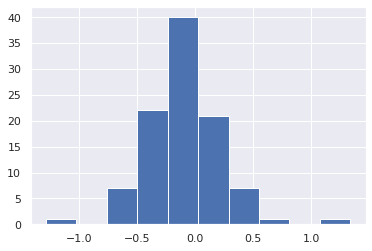

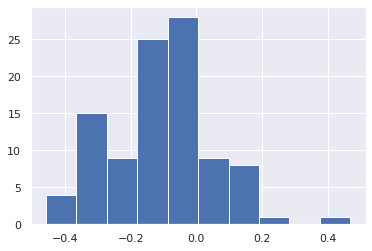

In [10]:

savetxt('./betas_sample.csv', proper_beta_samples, delimiter=',')
proper_beta_samples_cop = proper_beta_samples.copy()

# proper_beta_samples = proper_beta_samples_cop[100:]

proper_beta_samples_np = np.array(proper_beta_samples).T

# proper_beta_samples_np -= np.mean(proper_beta_samples_np, axis=1)
# proper_beta_samples_np /= np.var(proper_beta_samples_np, axis=1)

print(proper_beta_samples_np.T.shape)
proper_beta_samples_mean = np.mean(proper_beta_samples_np.T, axis=0)
print(proper_beta_samples_mean.shape)

# proper_beta_samples_mean -= np.mean(proper_beta_samples_mean)
# proper_beta_samples_mean /= np.var(proper_beta_samples_mean)
# proper_beta_samples_mean[np.abs(proper_beta_samples_mean) < 0.9] = 0
# print(len(proper_beta_samples_mean[proper_beta_samples_mean > 0]))


plt.hist(proper_beta_samples_mean)
plt.show()
plt.hist(betas)
plt.show()



100
(17,)


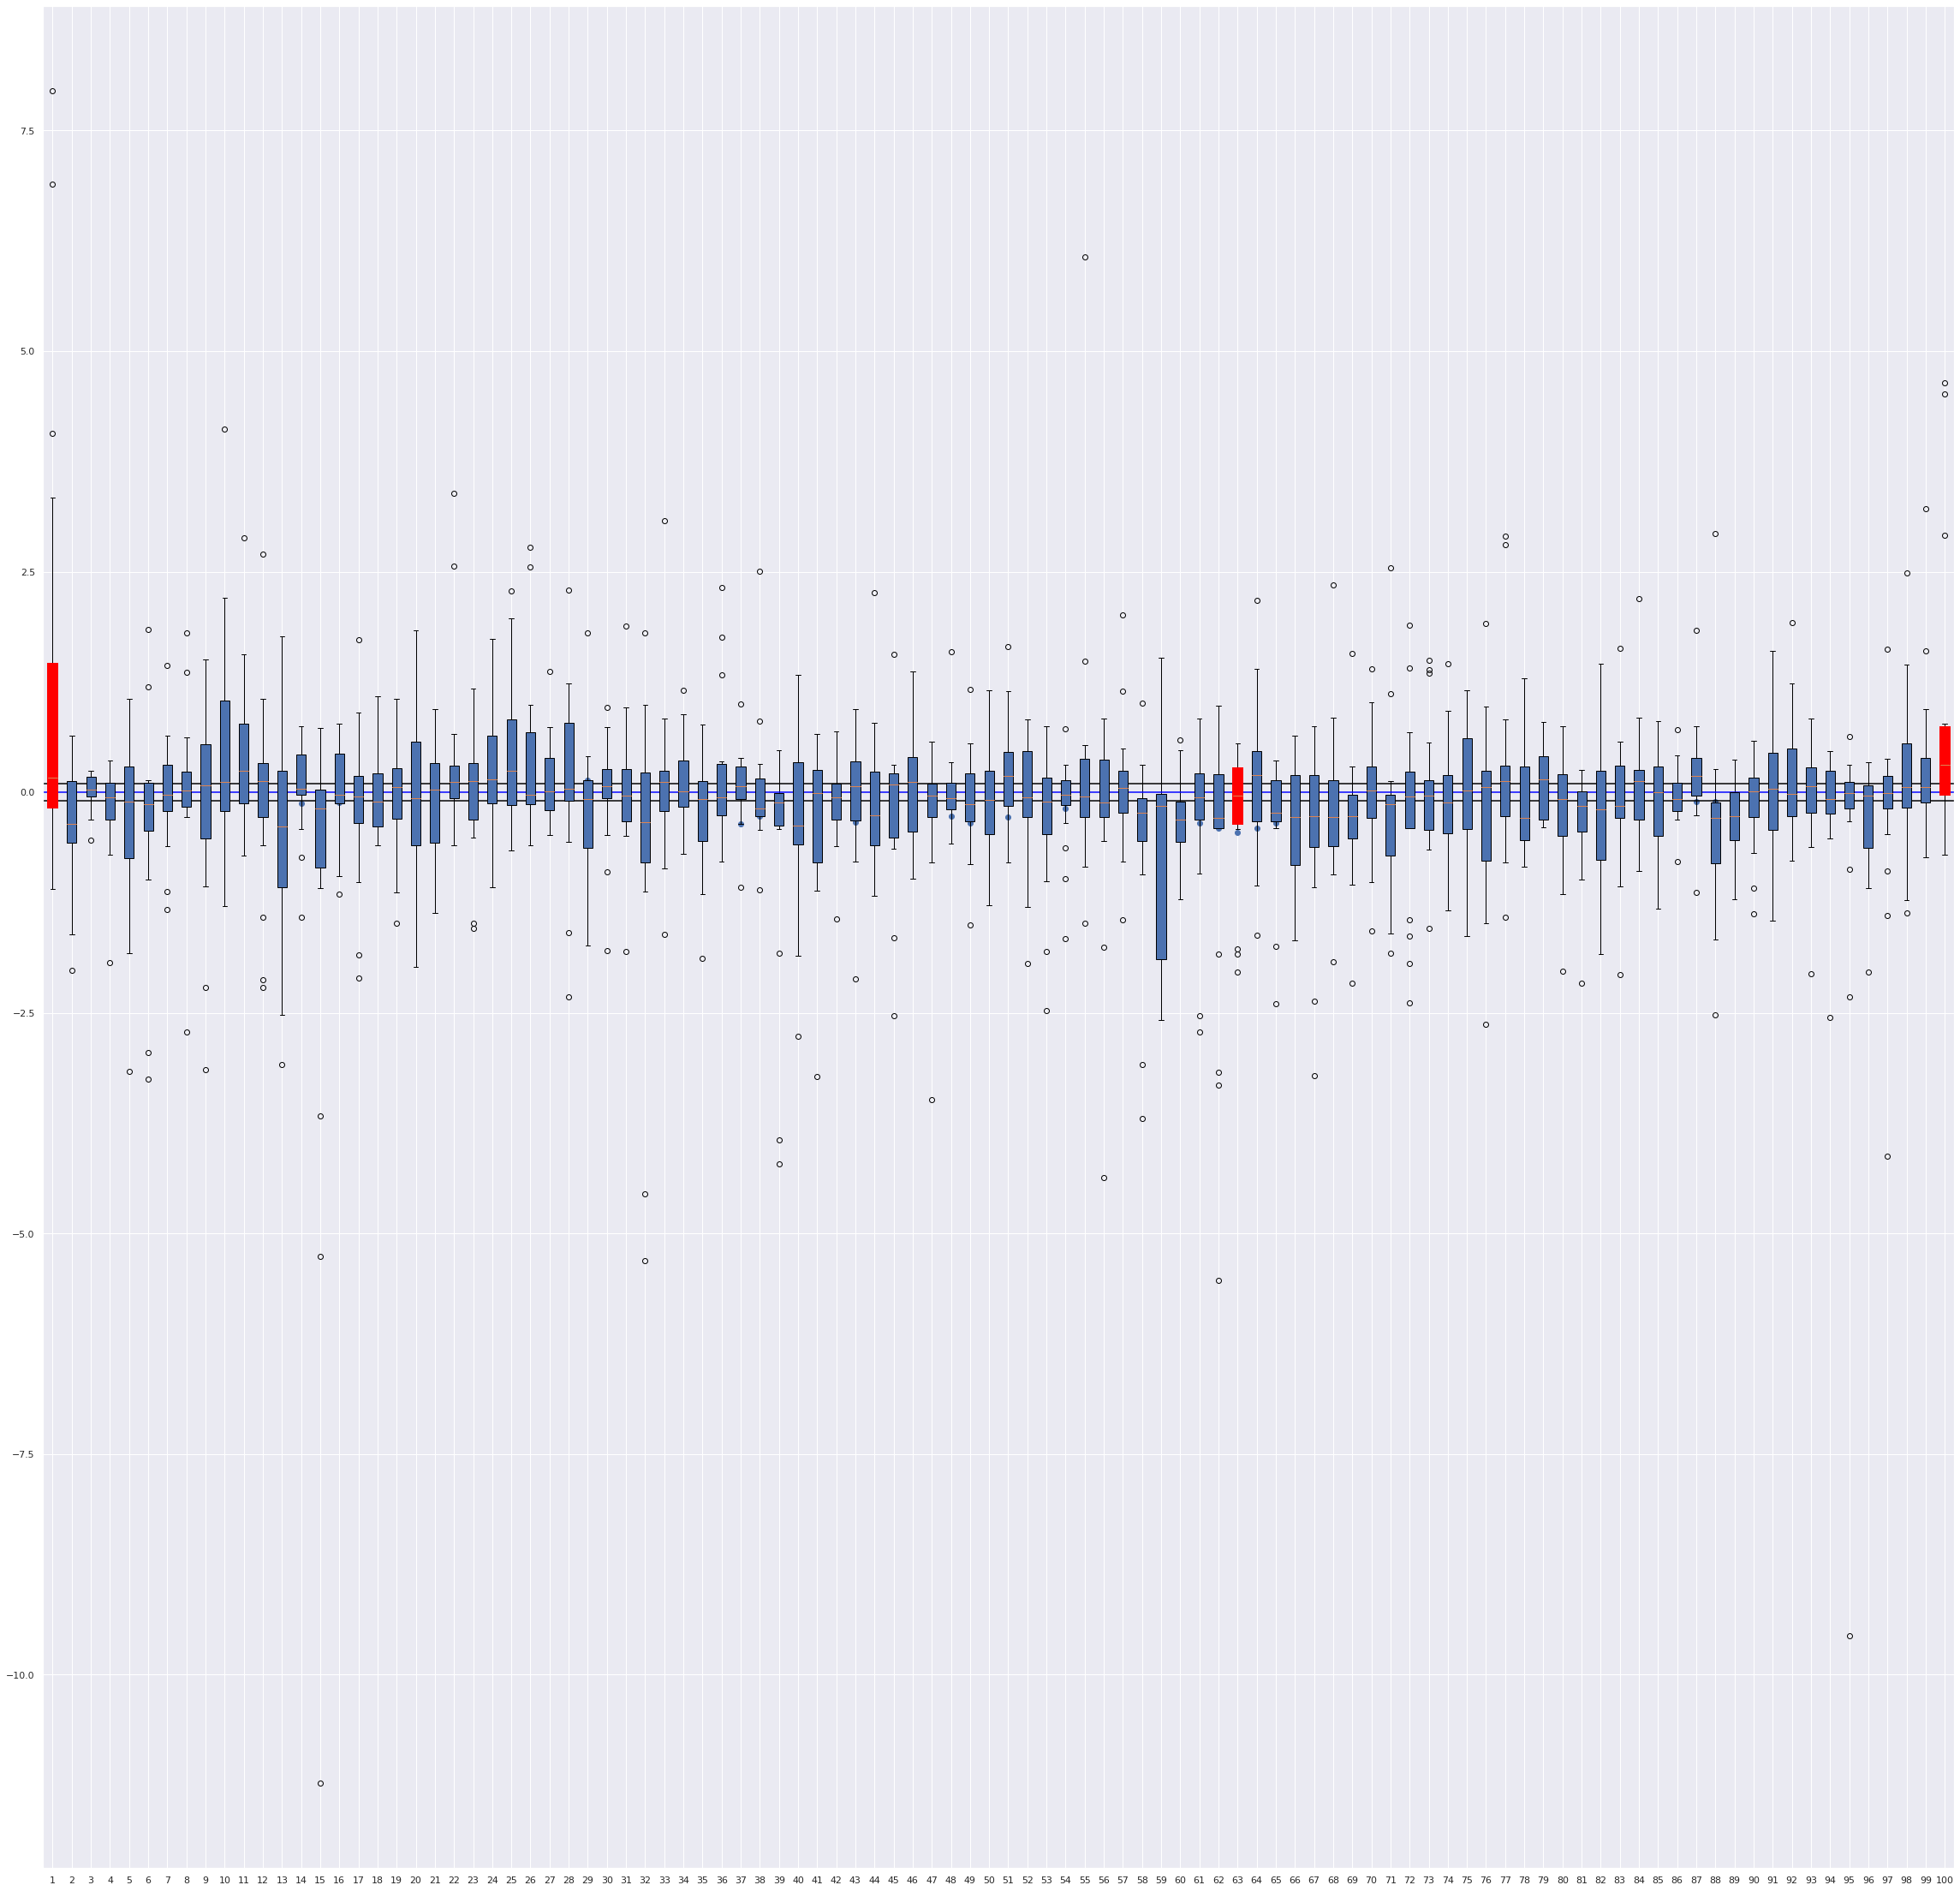

In [11]:
to_plot = []
for i in range(proper_beta_samples_np.shape[0]):
    to_plot += [proper_beta_samples_np[i, :]]

print(len(to_plot))
print(to_plot[0].shape)
fig=plt.figure(1,figsize=(40,40))
ax=fig.add_subplot(111)
bp=ax.boxplot(to_plot, patch_artist=True)

for i in causal:
    box = bp['boxes'][i]
    box.set(color='red', linewidth=2)
    box.set(facecolor = 'red')

plt.scatter(np.arange(len(to_plot)) + 1, betas)
plt.axhline(y=0.1, color='black', linestyle='-')
plt.axhline(y=0.0, color='blue', linestyle='-')
plt.axhline(y=-0.1, color='black', linestyle='-')

# plt.ylim([-5, 5])
fig.savefig('all_betas.pdf',bbox_inches='tight')
plt.show()

0.9276295027299813 validation
0.34420554615542054 validation correlation
0.8493661196882619 train
0.5401595903665025 train correlation
0.8460868230346874 test
0.504079079989476 test correlation


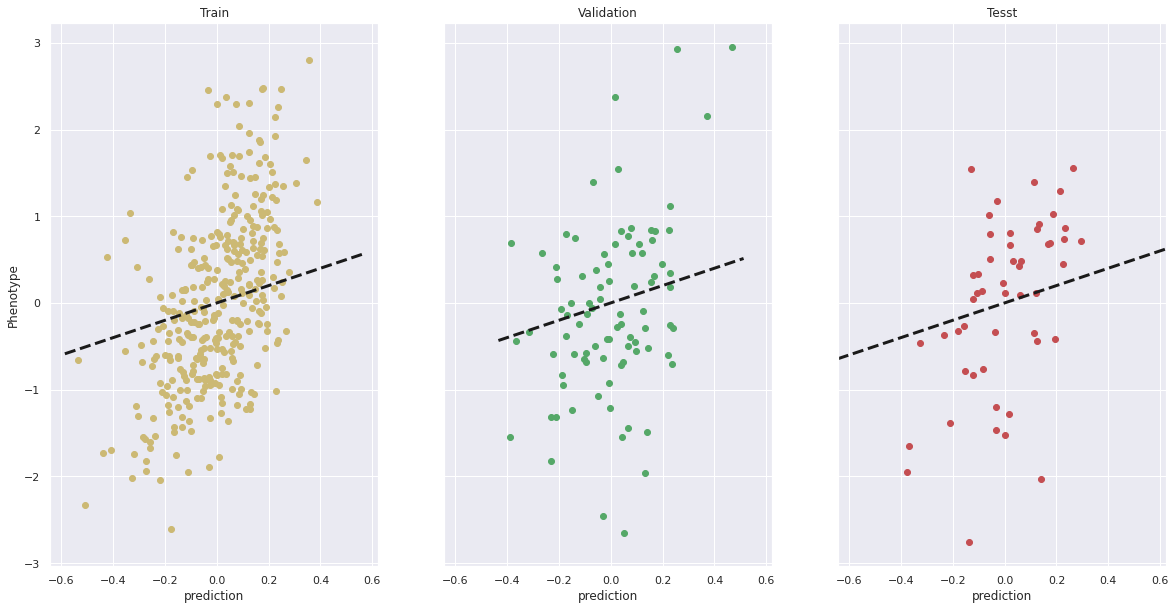

0.22232765104379346


In [12]:
figure, axis = plt.subplots(1,3, sharex=True, sharey=True, figsize=(20,10))

# del per
per = np.dot(val_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[1].scatter(per, val_phenotypes, color='g')
axis[1].set_title("Validation")
xpoints = ypoints = plt.xlim()
axis[1].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

EPSILON_PREV = np.mean((val_phenotypes - per) ** 2)

RES_DICT['linear model validation'] = np.mean((val_phenotypes - per) ** 2)
print(np.mean((val_phenotypes - per) ** 2), 'validation')
print(pearsonr(val_phenotypes, per)[0], 'validation correlation')

del per

per = np.dot(train_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[0].scatter(per, train_phenotypes, color='y')
axis[0].set_title("Train")
xpoints = ypoints = plt.xlim()
axis[0].plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

RES_DICT['linear model train'] = np.mean((train_phenotypes - per) ** 2)
print(np.mean((train_phenotypes - per) ** 2), 'train')
print(pearsonr(train_phenotypes, per)[0], 'train correlation')


del per

per = np.dot(test_genotypes, proper_beta_samples_mean)
per -= np.mean(per)
per /= np.var(per)

axis[2].scatter(per, test_phenotypes, color='r')
axis[2].set_title("Tesst")

xpoints = ypoints = plt.xlim()
plt.plot(xpoints, ypoints, linestyle='--', color='k', lw=3, scalex=False, scaley=False)

RES_DICT['linear model test'] = np.mean((test_phenotypes - per) ** 2)
print(np.mean((test_phenotypes - per) ** 2), 'test')
print(pearsonr(test_phenotypes, per)[0], 'test correlation')


for ax in axis.flat:
    ax.set(ylabel='Phenotype', xlabel='prediction')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axis.flat:
    ax.label_outer()

# plt.xlim(-1,1)
plt.show()
figure.savefig('proposed_model_res.pdf')

print(np.mean(np.abs(proper_beta_samples_mean - betas)))


In [13]:
import pickle
    
try:
    res_file = open('res_dict', 'wb')
    pickle.dump(RES_DICT, res_file)
    res_file.close()
  
except:
    print("Something went wrong")

In [14]:
# print(pd.read_csv("beta_marginal.csv").iloc['rs9482449',])
print(proper_beta_samples_mean[list(np.argsort(proper_beta_samples_mean)),][-20:,])
list(np.argsort(proper_beta_samples_mean))
pd.read_csv("beta_marginal.csv").iloc[list(np.argsort(proper_beta_samples_mean)),:].iloc[-20:,:]

[0.12892574 0.13508528 0.13906902 0.14014892 0.1620518  0.19097292
 0.2019873  0.20841919 0.20869827 0.23159264 0.26053175 0.29617724
 0.30642715 0.3631769  0.37147152 0.37945786 0.44039088 0.4707084
 0.8058799  1.3333511 ]


,Unnamed: 0,V1
32,rs9398738,-0.125029
33,rs9490824,0.194866
26,rs1321084,-0.121541
78,rs2611436,-0.127699
35,rs1590246,0.004940
91,rs342660,-0.034887
23,rs4897305,-0.067237
97,rs9482443,0.033834
86,rs12665623,-0.103834
50,rs9375280,-0.278068
